## MODEL 2

In this notebook we will attempt to optimize our model after adding a feature depicting the quantity of all stars a team traded for in a given season. In the teams table, we will see how the predictive power of preseason odds and midseason points (standings), as well as the trades are for the target variable of playoff wins (with 4 winning the Stanley Cup).

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

After the usual imports, we will import a csv which contains all NHL teams individual seasons from 2006 - 2023. We will keep the 2024 season off to the side until we have a model worth using to predict the outcome of the current season.

**Data Dictionary**
- TEAM - All teams active for each individual season (2006 - 2023). See notes below.
- Preseason_Odds - Signifies chances of winning stanley cup (lower suggests a better team). See notes below.
- Midseason_Pts - Total at each season's trade deadline (more points equals higher place in standings).
- Playoff_Wins - 0.0-4.0 for teams making Playoffs, NaN for teams that missed. 4.0 signifies the Stanley Cup Champion for each season.
- Traded_For_AS - Quantifies how many all-stars a team traded for in a given season.                                                                                                                  

**Notes:**
- Mighty Ducks of Anaheim renamed to Anaheim Ducks following 2005-06 season.
- Atlanta (Thrashers) moved thier franchise to Winnipeg (Jets) following the 2010-11 season.
- Phoenix Coyotes renamed as the Arizona Coyotes following the 2013-14 season.
- Preseason Odds are calculated as the return made on a $100 bet.
- All Stars are defined as a player who was voted into / played in an all star game within the 5 seasons prior, or 2 seasons following the season of trade.
- Playoff Wins are binned by how many rounds a team won.

In [31]:
teams = pd.read_csv('/Users/phil/Documents/Capstone/Data/NHL_Teams_AS1.csv')
teams

,TEAM,Preseason_Odds,Midseason_Pts,Playoff_Wins,Traded_For_AS
0,MightyDucksOfAnaheim_06,3000,70,2.0,NaN
1,AnaheimDucks_07,1200,84,4.0,NaN
2,AnaheimDucks_08,600,79,0.0,NaN
3,AnaheimDucks_09,1000,68,1.0,NaN
4,AnaheimDucks_10,1400,67,NaN,NaN
...,...,...,...,...,...
543,TorontoMapleLeafs_23,800,84,1.0,1.0
544,VancouverCanucks_23,5000,53,NaN,NaN
545,VegasGoldenKnights_23,1800,80,4.0,1.0
546,WashingtonCapitals_23,4000,66,NaN,NaN


In [32]:
teams['Playoff_Wins'] = teams['Playoff_Wins'].fillna(-1)
teams

,TEAM,Preseason_Odds,Midseason_Pts,Playoff_Wins,Traded_For_AS
0,MightyDucksOfAnaheim_06,3000,70,2.0,NaN
1,AnaheimDucks_07,1200,84,4.0,NaN
2,AnaheimDucks_08,600,79,0.0,NaN
3,AnaheimDucks_09,1000,68,1.0,NaN
4,AnaheimDucks_10,1400,67,-1.0,NaN
...,...,...,...,...,...
543,TorontoMapleLeafs_23,800,84,1.0,1.0
544,VancouverCanucks_23,5000,53,-1.0,NaN
545,VegasGoldenKnights_23,1800,80,4.0,1.0
546,WashingtonCapitals_23,4000,66,-1.0,NaN


In [33]:
teams['Traded_For_AS'] = teams['Traded_For_AS'].fillna(0)
teams

,TEAM,Preseason_Odds,Midseason_Pts,Playoff_Wins,Traded_For_AS
0,MightyDucksOfAnaheim_06,3000,70,2.0,0.0
1,AnaheimDucks_07,1200,84,4.0,0.0
2,AnaheimDucks_08,600,79,0.0,0.0
3,AnaheimDucks_09,1000,68,1.0,0.0
4,AnaheimDucks_10,1400,67,-1.0,0.0
...,...,...,...,...,...
543,TorontoMapleLeafs_23,800,84,1.0,1.0
544,VancouverCanucks_23,5000,53,-1.0,0.0
545,VegasGoldenKnights_23,1800,80,4.0,1.0
546,WashingtonCapitals_23,4000,66,-1.0,0.0


After reading in the Team data, we imputed nulls for Playoff Wins as -1.  This value corresponds to teams who missed the playoffs, as teams who made the playoffs, but did not advance are listed as a 0.  Additionally, for the All Star Trades, we impute a 0 for teams who did not trade for an all star.  In the data above, all stars are initially just a boolean value - did you trade for an all star or not.  All stars are defined as someone who has ever been an all star - whether that is someone who maybe well past their prime, or a young player who has yet to reach their potential.

In [34]:
teams_corr = teams[['Preseason_Odds','Midseason_Pts','Playoff_Wins','Traded_For_AS']].corr()

<Axes: >

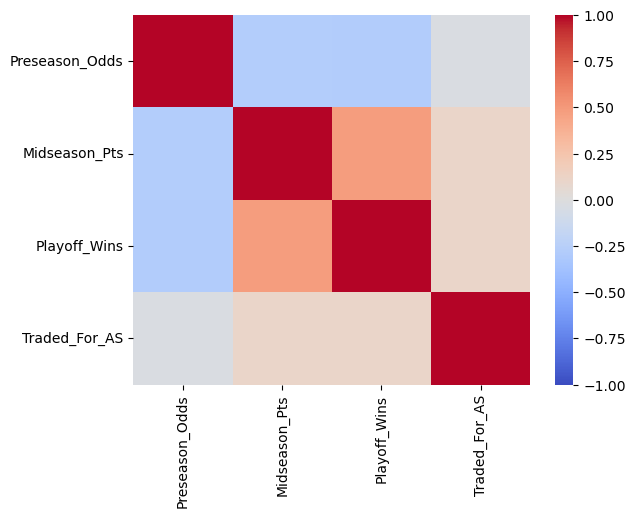

In [35]:
sns.heatmap(teams_corr,cmap='coolwarm',vmin=-1,vmax=1)

Next, we run a correlation heatmap to see how the different features interact with each other.  It is a bit surprising to see that preseason odds is negatively correlated with both midseason points and playoff wins, while it does make sense that midseason points and playoff wins do have some positive correlation.  Additionally, it was a bit surprising that All Star trades had such a correlation with the other features.

Next we will do some exploration running models to see how the feature of trading for an all star does or does not effect the prediction power of a team's playoff performance.  We will begin by splitting our data into training and testing sets, followed by scaling the data and running a simple logistic regression model.  These are the same steps we took to run our baseline model to see predictive power of our initial features - preseason odds and mideseason points.

In [36]:
X = teams[['Preseason_Odds','Midseason_Pts','Traded_For_AS']]
y = teams['Playoff_Wins']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [37]:
scaler = StandardScaler()

X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.fit_transform(X_test)

In [38]:
lr = LogisticRegression()
logreg = lr.fit(X_train_ss,y_train)
logreg_train_acc = logreg.score(X_train_ss,y_train)
logreg_test_acc = logreg.score(X_test_ss,y_test)
print(logreg_train_acc)
print(logreg_test_acc)

0.639269406392694
0.6181818181818182


In [39]:
logreg.coef_

array([[ 1.05130559, -1.46582747, -0.07333123],
       [ 0.49743403,  0.24198106,  0.01044917],
       [ 0.02103137,  0.46735257, -0.1635936 ],
       [ 0.07882579,  0.369183  ,  0.04013965],
       [ 0.15715799,  0.08992047,  0.02752821],
       [-1.80575477,  0.29739037,  0.15880779]])

While we do see values populating in our coefficients matrix, the logistic regression scores are the exact same between our baseline model and the one above.  This could potentially suggest data leakage, but lets also run some other models to see if we can get some different prediction scores.  We will begin by running some other classifiers - Logistic regression witha lasso penalty, a Ridge Classifier, as well as a Ridge Classifier using cross validation.

In [43]:
lr1 = LogisticRegression(penalty='l1', solver='saga',max_iter=10000)
logreg1 = lr1.fit(X_train_ss,y_train)
logreg_train_acc1 = logreg1.score(X_train_ss,y_train)
logreg_test_acc1 = logreg1.score(X_test_ss,y_test)
print(logreg_train_acc1)
print(logreg_test_acc1)

0.639269406392694
0.6181818181818182


In [44]:
clf = RidgeClassifier().fit(X_train_ss,y_train)
r_train = clf.score(X_train_ss,y_train)
r_test = clf.score(X_test_ss,y_test)

print(r_train)
print(r_test)

0.6187214611872146
0.6272727272727273


In [46]:
clf = RidgeClassifierCV().fit(X_train_ss,y_train)
rcv_train = clf.score(X_train_ss,y_train)
rcv_test = clf.score(X_test_ss,y_test)

print(rcv_train)
print(rcv_test)

0.6210045662100456
0.6272727272727273


After running the tests above, we do see some slight differences, however they are so minimal, there is still a potential issue of data leakage.  Additionally, it maybe worth adding a time aspect to the definition of who qualifies as an all star in a trade. In the new dataframe below, the Traded_For_AS feature only considers all stars as a player who has been an all star in the previous 5 years or succeeding 2 seasons.  By doing this we can mitigate for players who maybe are often older and / or injured, or players who are young, but yet to reach thier potential.

In [47]:
teams2 = pd.read_csv('/Users/phil/Documents/Capstone/Data/NHL_Teams_AS2.csv')
teams2

,TEAM,Preseason_Odds,Midseason_Pts,Playoff_Wins,Traded_For_AS
0,MightyDucksOfAnaheim_06,3000,70,2.0,NaN
1,AnaheimDucks_07,1200,84,4.0,NaN
2,AnaheimDucks_08,600,79,0.0,NaN
3,AnaheimDucks_09,1000,68,1.0,NaN
4,AnaheimDucks_10,1400,67,NaN,NaN
...,...,...,...,...,...
543,TorontoMapleLeafs_23,800,84,1.0,1.0
544,VancouverCanucks_23,5000,53,NaN,NaN
545,VegasGoldenKnights_23,1800,80,4.0,NaN
546,WashingtonCapitals_23,4000,66,NaN,NaN


In [48]:
teams2['Playoff_Wins'] = teams2['Playoff_Wins'].fillna(-1)
teams2

,TEAM,Preseason_Odds,Midseason_Pts,Playoff_Wins,Traded_For_AS
0,MightyDucksOfAnaheim_06,3000,70,2.0,NaN
1,AnaheimDucks_07,1200,84,4.0,NaN
2,AnaheimDucks_08,600,79,0.0,NaN
3,AnaheimDucks_09,1000,68,1.0,NaN
4,AnaheimDucks_10,1400,67,-1.0,NaN
...,...,...,...,...,...
543,TorontoMapleLeafs_23,800,84,1.0,1.0
544,VancouverCanucks_23,5000,53,-1.0,NaN
545,VegasGoldenKnights_23,1800,80,4.0,NaN
546,WashingtonCapitals_23,4000,66,-1.0,NaN


In [49]:
teams2['Traded_For_AS'] = teams2['Traded_For_AS'].fillna(0)
teams2

,TEAM,Preseason_Odds,Midseason_Pts,Playoff_Wins,Traded_For_AS
0,MightyDucksOfAnaheim_06,3000,70,2.0,0.0
1,AnaheimDucks_07,1200,84,4.0,0.0
2,AnaheimDucks_08,600,79,0.0,0.0
3,AnaheimDucks_09,1000,68,1.0,0.0
4,AnaheimDucks_10,1400,67,-1.0,0.0
...,...,...,...,...,...
543,TorontoMapleLeafs_23,800,84,1.0,1.0
544,VancouverCanucks_23,5000,53,-1.0,0.0
545,VegasGoldenKnights_23,1800,80,4.0,0.0
546,WashingtonCapitals_23,4000,66,-1.0,0.0


Again we begin with this new dataset by imputing -1 for the Playoff win columns for teams who did not make the playoffs, as well as 0 for teams who did not acquire an all star in their midseason trade activity.  We follow this by again running a correlation heatmap to see if there is any difference in how the new definition of an all star correlates with the other features.

<Axes: >

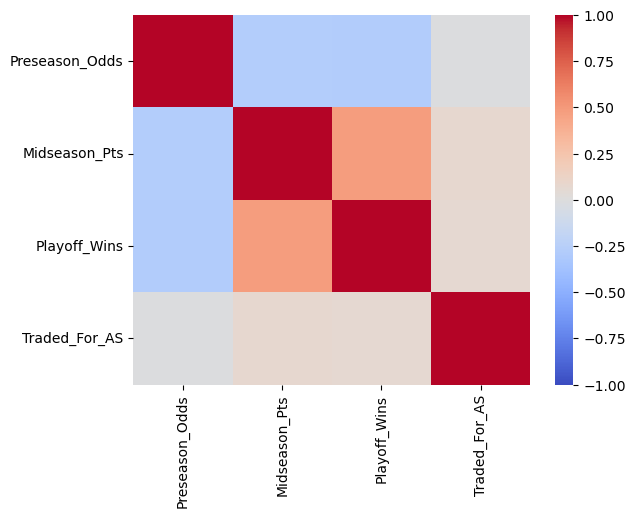

In [51]:
teams_corr2 = teams2[['Preseason_Odds','Midseason_Pts','Playoff_Wins','Traded_For_AS']].corr()
sns.heatmap(teams_corr2,cmap='coolwarm',vmin=-1,vmax=1)

Unfortunately, it does not appear to have much effect at all when we look at the new definition of who classifies as an all star.  That said, we will run through some models to further assess.  As we did above, we will begin by splitting our data to train and test, scaling, and running through some regression models.

In [55]:
X = teams2[['Preseason_Odds','Midseason_Pts','Traded_For_AS']]
y = teams2['Playoff_Wins']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [56]:
scaler = StandardScaler()

X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.fit_transform(X_test)

In [57]:
lr = LogisticRegression()
logreg = lr.fit(X_train_ss,y_train)
logreg_train_acc = logreg.score(X_train_ss,y_train)
logreg_test_acc = logreg.score(X_test_ss,y_test)
print(logreg_train_acc)
print(logreg_test_acc)

0.639269406392694
0.6272727272727273


In [58]:
logreg.coef_

array([[ 1.05200719, -1.46501796, -0.0712878 ],
       [ 0.50604154,  0.2397991 ,  0.06332147],
       [ 0.03363277,  0.45383543, -0.07412211],
       [ 0.071674  ,  0.37538359, -0.00815906],
       [ 0.15898716,  0.0902434 ,  0.04585129],
       [-1.82234266,  0.30575643,  0.04439621]])

In [59]:
lr1 = LogisticRegression(penalty='l1', solver='saga',max_iter=10000)
logreg1 = lr1.fit(X_train_ss,y_train)
logreg_train_acc1 = logreg1.score(X_train_ss,y_train)
logreg_test_acc1 = logreg1.score(X_test_ss,y_test)
print(logreg_train_acc1)
print(logreg_test_acc1)

0.639269406392694
0.6272727272727273


In [60]:
clf = RidgeClassifier().fit(X_train_ss,y_train)
r_train = clf.score(X_train_ss,y_train)
r_test = clf.score(X_test_ss,y_test)

print(r_train)
print(r_test)

0.6232876712328768
0.6272727272727273


In [61]:
clf = RidgeClassifierCV().fit(X_train_ss,y_train)
rcv_train = clf.score(X_train_ss,y_train)
rcv_test = clf.score(X_test_ss,y_test)

print(rcv_train)
print(rcv_test)

0.6187214611872146
0.6363636363636364


The models do end up having some slight differences from above and our baseline model.  That said the differences are still minimal.  Let's try to run a Random Forest model (RFC) in attempt to see if a different type of model with have different effects on our predicting power.  We will begin by running a simple RFC, followed by running both the RFC and Logistic Regression models through a pipeline and gridsearch to find the optimal hyperparameters.

In [63]:
clf = RandomForestClassifier().fit(X_train_ss,y_train)
rtc_train = clf.score(X_train_ss,y_train)
rtc_test = clf.score(X_test_ss,y_test)

print(rtc_train)
print(rtc_test)

0.9497716894977168
0.5909090909090909


While the test data does not have a significant difference, and is actually slightly lower than our Regression models, it is relieving to see some different numbers and a high training score. Again, lets run through our pipleling and gridsearch to optimize both an RFC and a Logistic Regession model.

In [72]:
pipe = Pipeline([("scaler", StandardScaler()),
                ("clf", RandomForestClassifier())])

param_grid = [{'clf__n_estimators': [10,50,100,500,1000],
             'clf__max_depth': [1,2,3,4,5,6,7,8,9,10]}]
             
grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)         

In [73]:
fittedgrid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(max_depth=3, n_estimators=500))])

In [104]:
fittedgrid.best_estimator_.steps[1][1].feature_imp

array([0.31337196, 0.64603022, 0.04059782])

In [74]:
fittedgrid.best_params_

{'clf__max_depth': 3, 'clf__n_estimators': 500}

In [75]:
fittedgrid.cv_results_['mean_test_score']

array([0.56852142, 0.58445664, 0.59811912, 0.57985893, 0.58445664,
       0.58897597, 0.62554859, 0.63469175, 0.63241902, 0.63012017,
       0.61862591, 0.63474399, 0.64156217, 0.64386102, 0.64156217,
       0.63009404, 0.63701672, 0.63247126, 0.63928945, 0.6369906 ,
       0.62327586, 0.62335423, 0.63244514, 0.62789969, 0.63017241,
       0.59824974, 0.61418495, 0.62102926, 0.62332811, 0.61875653,
       0.59589864, 0.61183386, 0.59822362, 0.60276907, 0.60731452,
       0.58680773, 0.57306688, 0.59137931, 0.59135319, 0.59589864,
       0.55485893, 0.56857367, 0.56619645, 0.58226228, 0.5776907 ,
       0.56402821, 0.55263845, 0.5434953 , 0.56405434, 0.55488506])

In [93]:
clf_best = RandomForestClassifier(max_depth=3,n_estimators=500).fit(X_train_ss,y_train)
rfc_train2 = clf_best.score(X_train_ss,y_train)
rfc_test2 = clf_best.score(X_test_ss,y_test)

print(rfc_train2)
print(rfc_test2)

0.6484018264840182
0.6181818181818182


When running our Random Forest again with the optimal hyperparameters, we find that there is significantly less overfitting than our initial RFC, that said, our test score ends up the exact same as our baseline prediction score.

In [94]:
y_pred_rfc = clf_best.predict(X_test_ss)

cf_matrix = confusion_matrix(y_test, y_pred_rfc)

cf_df = pd.DataFrame(cf_matrix)

display(cf_df)

,0,1,2,3,4,5
0,43,8,0,0,0,0
1,7,25,0,0,0,0
2,6,6,0,0,0,0
3,0,7,0,0,0,0
4,0,4,0,0,0,0
5,0,4,0,0,0,0


In [95]:
report = classification_report(y_test, y_pred_rfc)
print(report)

              precision    recall  f1-score   support

        -1.0       0.77      0.84      0.80        51
         0.0       0.46      0.78      0.58        32
         1.0       0.00      0.00      0.00        12
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         4

    accuracy                           0.62       110
   macro avg       0.21      0.27      0.23       110
weighted avg       0.49      0.62      0.54       110



/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


When running through further evaluation of the Random Forest, we see strong ability to predict a team missing the playoffs, and some attempts at predicting a team to make the playoffs and not advance.  However, the model does not make any attempt to predict teams advancing any further.

In [81]:
pipe_lr = Pipeline([("scaler", StandardScaler()),
                ("model", LogisticRegression())])

param_grid_lr = [{'scaler': [StandardScaler()],
             'model': [LogisticRegression(solver='saga',max_iter=10000)], 
             'model__C': np.logspace(-3,3,7),
             'model__penalty': ['l1', 'l2']}]
             
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5)
fittedgrid_lr = grid_lr.fit(X_train, y_train)     

In [82]:
fittedgrid_lr.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    solver='saga'))])

In [83]:
fittedgrid_lr.best_params_

{'model': LogisticRegression(max_iter=10000, solver='saga'),
 'model__C': 0.1,
 'model__penalty': 'l1',
 'scaler': StandardScaler()}

In [84]:
fittedgrid_lr.cv_results_['mean_test_score']

array([0.45890805, 0.45890805, 0.45890805, 0.58672936, 0.62560084,
       0.61873041, 0.62332811, 0.62105538, 0.62105538, 0.62332811,
       0.62332811, 0.62105538, 0.62332811, 0.62332811])

In [86]:
lr_best = LogisticRegression(C=0.1,max_iter=10000,penalty='l1',solver='saga')
logreg2 = lr_best.fit(X_train_ss,y_train)
logreg_train_acc2 = logreg2.score(X_train_ss,y_train)
logreg_test_acc2 = logreg2.score(X_test_ss,y_test)
print(logreg_train_acc2)
print(logreg_test_acc2)

0.6278538812785388
0.6272727272727273


As mentioned, we did the same with our Logistic Regression as we did with the Random Forest.  When running our LR again with the optimal hyperparameters, we find that we have virtually no overfitting, but the model does only slightly better than our baseline model, and actually does not perform as well as our Ridge Classifier with Cross Validation.

In [96]:
y_pred_lr = logreg2.predict(X_test_ss)

cf_matrix = confusion_matrix(y_test, y_pred_lr)

cf_df = pd.DataFrame(cf_matrix)

display(cf_df)

,0,1,2,3,4,5
0,45,6,0,0,0,0
1,8,24,0,0,0,0
2,6,6,0,0,0,0
3,0,7,0,0,0,0
4,0,4,0,0,0,0
5,0,4,0,0,0,0


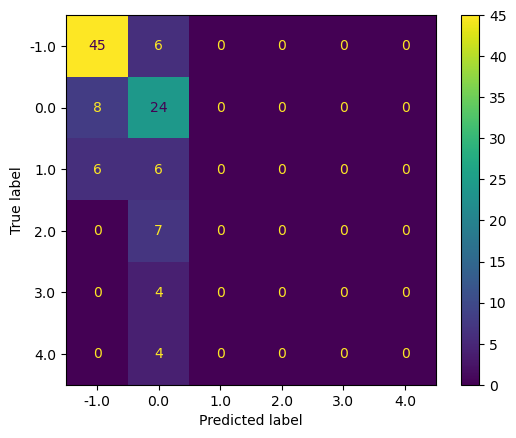

In [89]:
ConfusionMatrixDisplay.from_estimator(logreg2, X_test_ss, y_test)

In [97]:
report = classification_report(y_test, y_pred_lr)
print(report)

              precision    recall  f1-score   support

        -1.0       0.76      0.88      0.82        51
         0.0       0.47      0.75      0.58        32
         1.0       0.00      0.00      0.00        12
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         4

    accuracy                           0.63       110
   macro avg       0.21      0.27      0.23       110
weighted avg       0.49      0.63      0.55       110



/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


After running further model evaluation, we can see the model became good at predicting whether a team would or would not make the playoffs, however, it did not actually make any predictions on a team advancing past the first round.  This could be due to the lack of test size of the data.  Despite the vast amount of data overall, the scope of this portion of the project reduced the data to few rows and columns to predict more accurately.

In [173]:
# Make probabilistic predictions (scores)
y_proba = logreg2.predict_proba(X_test_ss)[:,1]

# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold,average='macro')}")
print(f"Recall score: {recall_score(y_test, y_threshold,average='macro')}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.55, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold,average='macro')}")
print(f"Recall score: {recall_score(y_test, y_threshold,average='macro')}")

Threshold of 0.5:
Precision score: 0.07745726495726496
Recall score: 0.1753472222222222

Threshold of 0.2:
Precision score: 0.048484848484848485
Recall score: 0.16666666666666666


/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phil/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


When trying to look into increasing precision, in effort to have more predictions on the latter rounds of the playoffs, the prediction scores decreased significantly for both precision and recall - so perhaps this is not the best type of tuning for this model.

**CONCLUSION**
After running these models through, we can suspect there is still potentially some data leakage, or potentially we just need more features to run through the model in effort to offer more for the models to learn in effort to improve our prediction power.  But given our current situation, we can say that a team trading for an all star does not have a significant effect on our ability to predict a team's playoff success.

Other than looking into adding additional features to our model, perhaps we also need to further explore the definition of an all star.  Potential issues with the current definition - there is a popularity aspect to the all star voting ; every team needs a representative, someone maybe the best player on a bad team, a good team's fourth best player may still be superior.  Given enough time, running an additional project modeling which player attributes (i.e. Age), statistics (Points per Game), and accolades (NHL Awards, Olympics), could be a better determination of who is 'all-star caliber' rather than who is actually an all-star.

Ultimately, there are so many factors that may contribute to a team's trade deadline strategy, such as injuries, future assets (i.e. draft picks and prospects), that it's possible more / improved features will still not have an effect on our prediction ability, but we can aspire to find this should it exist.